# Velocity Perturbations

This code was primarily designed to study how velocity perturbations manifest in channel maps. The idea being that if we are able constrain how the emission is moving in a channel map, we should be able to say something about the underlying velcoity profile.

In [1]:
# Prep the Notebook
import numpy as np
import matplotlib.pyplot as plt
from simple_disk import simple_disk

# Generate a simple_disk instance.
disk = simple_disk(inc=40.0, PA=30.0, mstar=2.0, FOV=5.0, Npix=512)

## Perturbations

In `simple_disk`, all of the velocity perturbations are built as Gaussian distributions in the disk cylindrical coordinates, specified by a center, $(r_0,\, \phi_0)$, and their widths, $(\delta r,\, \delta \phi)$, implemeneted as the standard deviation of the Gaussian,

$$\delta v_i = \delta v_{i,\, 0} \exp\left[ -\frac{1}{2}\frac{(r - r_0)^2}{\delta r^2} \right] \exp\left[ -\frac{1}{2}\frac{(\phi - \phi_0)^2}{\delta \phi^2} \right]$$

This is returned by the hidden `_perturbation` function, where both angular values are given in degrees. If `projection='sky'` then the radial values are given in arcseconds, while for `projection='disk'` they are in au. Note that if $\delta \phi = 0$, then the perturbation is assumed to be annular.


### Projection

These deviations are then projected onto the sky with the following transformations:

$$\delta v_{\phi,\, {\rm proj}} = \delta v_{\phi} \cos(\phi) \sin(i), \qquad \delta v_{r,\, {\rm proj}} = \delta v_r \sin(\phi) \sin(i), \qquad \delta v_{z,\, {\rm proj}} = \delta v_z \cos(i)$$

Noting that the vertical motions do _not_ have an azimuthal dependence. These can be readily accessed with the following functions:

* `rotational_perturbation` for $\delta v_{\phi}$
* `radial_perturbation` for $\delta v_{r}$
* `vertical_perturbation` for $\delta v_{z}$

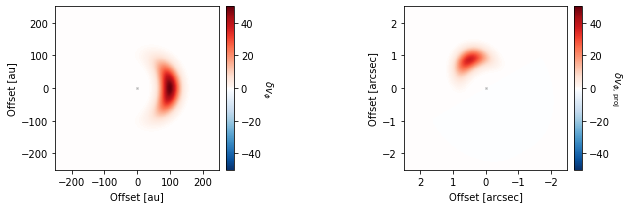

In [2]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
dv = disk.rotational_perturbation(dv=50.0, r0=100.0, t0=0.0, dr=20.0, dt=30.0, projection='disk')
im = ax.imshow(dv, origin='lower', extent=disk.extent_disk, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_disk_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi}$', rotation=270, labelpad=13)

ax = axs[1]
dv = disk.rotational_perturbation(dv=50.0, r0=1.0, t0=0., dr=0.2, dt=30.0, projection='sky')
im = ax.imshow(dv, origin='lower', extent=disk.extent_sky, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_sky_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi,\, {\rm proj}}$', rotation=270, labelpad=13)

plt.tight_layout()

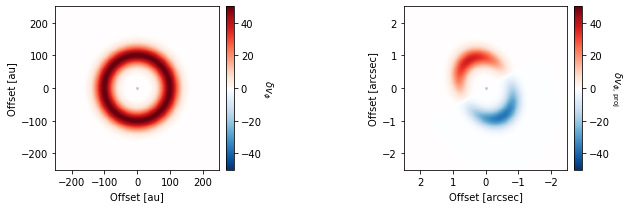

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
dv = disk.rotational_perturbation(dv=50.0, r0=100.0, t0=0.0, dr=20., dt=0.0, projection='disk')
im = ax.imshow(dv, origin='lower', extent=disk.extent_disk, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_disk_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi}$', rotation=270, labelpad=13)

ax = axs[1]
dv = disk.rotational_perturbation(dv=50.0, r0=1.0, t0=0.0, dr=0.2, dt=0.0, projection='sky')
im = ax.imshow(dv, origin='lower', extent=disk.extent_sky, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_sky_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi,\, {\rm proj}}$', rotation=270, labelpad=13)

plt.tight_layout()

It's important to note that given the projection, rotational or radial velocity deviations may change sign (see the Appendix of [Teague et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...884L..56T/abstract)).

## Spirals

Thanks to [Jaehan Bae](https://dtm.carnegiescience.edu/people/postdoctoral/jaehan-bae) users can also implement a spiral structure with a fixed pitch angle, $\beta$, given in degrees.

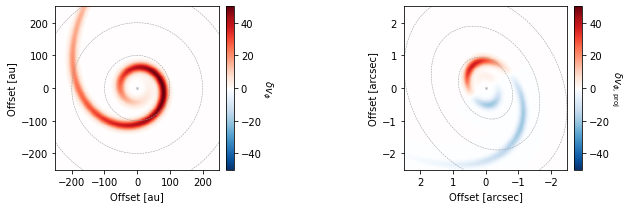

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
dv = disk.rotational_perturbation(dv=50.0, r0=80.0, t0=0.0, dr=10.0, dt=150.0, beta=10.0, projection='disk')
im = ax.imshow(dv, origin='lower', extent=disk.extent_disk, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_disk_plot(ax)
disk.plot_radii(ax, rvals=[100., 200., 300.], projection='disk')
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi}$', rotation=270, labelpad=13)

ax = axs[1]
dv = disk.rotational_perturbation(dv=50.0, r0=0.8, t0=0., dr=0.1, dt=150.0, beta=10.0, projection='sky')
im = ax.imshow(dv, origin='lower', extent=disk.extent_sky, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_sky_plot(ax)
disk.plot_radii(ax, rvals=[1., 2., 3.], projection='sky')
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi,\, {\rm proj}}$', rotation=270, labelpad=13)

plt.tight_layout()

**Note:** For very tightly wound spirals, you may need to increase the `disk.nwrap` parameter from its default value of 3. This will obviously increase calculation time (as `disk.nwrap` maps are created and summed), but will allow for spirals to wrap several times over.


## Influence on Channel Maps

We can then included these perturbations into the velocity structure to make our pseudo-channel maps with the additional argument `dv0` in the `get_channel` or `get_cube` functions.

**Note** These must be given from the sky-plane projection.

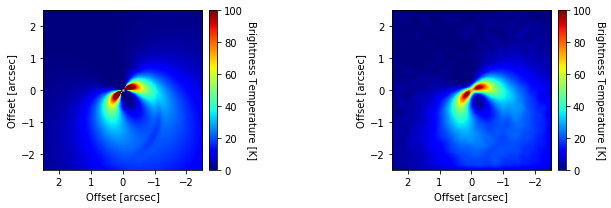

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
dv = disk.rotational_perturbation(dv=50.0, r0=0.8, t0=0., dr=0.1, dt=150.0, beta=10.0, projection='sky')
im = ax.imshow(disk.get_channel(v_min=-150., v_max=-50., dv0=dv),
               origin='lower', extent=disk.extent_sky,
               vmin=0, vmax=100, cmap='jet')
disk.format_sky_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label('Brightness Temperature [K]', rotation=270, labelpad=13)

ax = axs[1]
im = ax.imshow(disk.get_channel(v_min=-150., v_max=-50., dv0=dv, bmaj=0.2, rms=0.5),
               origin='lower', extent=disk.extent_sky,
               vmin=0, vmax=100, cmap='jet')
disk.format_sky_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label('Brightness Temperature [K]', rotation=270, labelpad=13)

plt.tight_layout()


## Complex Perturbations

As we have assumed a geometrically thin disk, the velocity deviations can simply be added together to mimic the spatial form of what we see in simulations. This can be done by the user, but one commonly used example is a 'Doppler flip', as discussed in [Casassus & Perez (2018)](https://ui.adsabs.harvard.edu/abs/2019ApJ...883L..41C/abstract). This is simply two Gaussian perturbations offset in radius and azimuth.

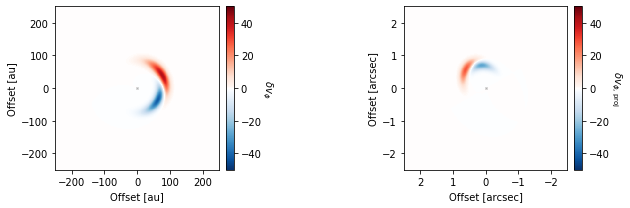

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
dv = disk.doppler_flip(dv=50.0, r0=80.0, t0=0.0, dr=10.0, dt=30.0, clockwise=True, projection='disk')
im = ax.imshow(dv, origin='lower', extent=disk.extent_disk, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_disk_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi}$', rotation=270, labelpad=13)

ax = axs[1]
dv = disk.doppler_flip(dv=50.0, r0=0.8, t0=0.0, dr=0.1, dt=30.0, clockwise=True, projection='sky')
im = ax.imshow(dv, origin='lower', extent=disk.extent_sky, cmap=disk.BuRd(), vmin=-50, vmax=50)
disk.format_sky_plot(ax)
cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label(r'$\delta v_{\phi,\, {\rm proj}}$', rotation=270, labelpad=13)

plt.tight_layout()

## Combined Figure

In [7]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator

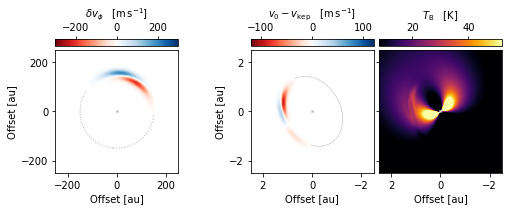

In [8]:
# doppler flip comparison.

dv = 300.  # velocity of the perturbations in [m/s]
r0 = 150.  # radius of flip center in [au]
t0 = 70.   # polar angle of flip center in [deg]
dr = 10.   # radial width in [au]
dt = 20.   # arc length of flip in [au]

# we use here trim_values to cut out all velocity perturbations less than +\- 1m/s for plotting.

dv_sky = disk.doppler_flip(dv, r0 / disk.dist, t0, dr / disk.dist, dt, projection='sky', trim_values=1.0)
dv_disk = disk.doppler_flip(dv, r0, t0, dr, dt, projection='disk', trim_values=1.0)

# make the figure 

fig, axs = plt.subplots(ncols=4, figsize=(8, 3), gridspec_kw=dict(width_ratios=(1, 0.5, 1, 1), wspace=0.05))

# in the disk plane

ax = axs[0]
ax.scatter(0, 0, marker='x', color='0.7', lw=1.0, s=4)

im = ax.imshow(dv_disk, origin='lower', vmin=-dv, vmax=dv,
               extent=disk.extent_disk, cmap=disk.RdBu())
cax = make_axes_locatable(ax).append_axes('top', size='6%', pad=0.05)
cb = plt.colorbar(im, cax=cax, orientation='horizontal')
cb.set_label(r'$\delta v_{\phi} \quad [{\rm m\,s^{-1}}]$')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
ax.contour(disk.xaxis_disk, disk.yaxis_disk, disk.r_disk, [r0],
           linestyles=':', linewidths=1.0, colors='0.7', zorder=-1)
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.set_xlabel('Offset [au]')
ax.set_ylabel('Offset [au]')
ax.set_title('Disk Midplane', fontsize=7)

# buffer axis

axs[1].axis('off')

# in the sky plane

ax = axs[2]
ax.scatter(0, 0, marker='x', color='0.7', lw=1.0, s=4)

im = ax.imshow(dv_sky, origin='lower', vmin=-120, vmax=120,
               extent=disk.extent_sky, cmap=disk.RdBu())
disk.plot_radii(ax, rvals=[r0/disk.dist], contour_kwargs=dict(zorder=-1))
cax = make_axes_locatable(ax).append_axes('top', size='6%', pad=0.05)
cb = plt.colorbar(im, cax=cax, orientation='horizontal')
cb.set_label(r'$v_0 - v_{\rm kep} \quad [{\rm m\,s^{-1}}]$')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
ax.set_xlabel('Offset [au]')
ax.set_ylabel('Offset [au]')
ax.set_title('On-Sky Projection', fontsize=7)

# channel map deviation

ax = axs[3]
ax.scatter(0, 0, marker='x', color='1.0', lw=1.0, s=4)
dv_sky = disk.doppler_flip(dv, r0 / disk.dist, t0, dr / disk.dist, dt, projection='sky')
channel = disk.get_channel(v_min=0, v_max=150, dv0=dv_sky)
im = ax.imshow(channel, origin='lower', vmin=8, vmax=52, extent=disk.extent_sky, cmap='inferno')
cax = make_axes_locatable(ax).append_axes('top', size='6%', pad=0.05)
cb = plt.colorbar(im, cax=cax, orientation='horizontal')
cb.set_label(r'$T_{\rm B} \quad [{\rm K}]$')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
ax.set_xlabel('Offset [au]')
ax.set_yticklabels([])
ax.set_title('Representitive Channel', fontsize=7)

plt.savefig('dopplerflip_comparison.pdf', bbox_inches='tight', dpi=300)